In [ ]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

2023-05-19 02:48:21.014896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [4]:
import pandas as pd
from pandas.io.parsers.readers import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from re import sub
import numpy as np

import multiprocessing

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential, Model
from keras import layers

In [6]:
path_to_work_folder = "/content/drive/MyDrive/Colab_Notebooks/PJATK-II/SEM3/ZUM/NLPPRO/"

In [99]:
path_to_tweets = f"{path_to_work_folder}tweets45k.csv"

In [100]:
tweets = pd.read_csv(path_to_tweets, sep="\t")

In [101]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44776 entries, 0 to 44775
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         44776 non-null  object
 1   created_at   44776 non-null  object
 2   likes        44776 non-null  int64 
 3   retweets     44776 non-null  int64 
 4   impressions  44776 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.7+ MB


In [ ]:
tweets.sample(10)

,text,created_at,likes,retweets,impressions
39520,@JeffRaines1 Those helicopters were tricked ou...,2023-05-13 21:50:40+00:00,12,2,674
22626,@McFaul Hell no! We are sick of Ukraine and ...,2023-05-15 22:53:24+00:00,2,0,7
11443,@vonderleyen @avalaina @coe It is urgent to se...,2023-05-17 12:07:10+00:00,0,0,10
3507,@zanupf_patriots Are this not captured helicop...,2023-05-18 14:22:10+00:00,0,0,474
26193,@TimInHonolulu 😂😂😂😂😂😂😂 how lying help Ukraine ...,2023-05-15 14:13:23+00:00,1,0,94
28244,"@MCM54321 I don't use the word evil, it's too ...",2023-05-15 09:39:10+00:00,2,0,76
12245,⚡️ #Ukraine should hold elections during the w...,2023-05-17 09:41:01+00:00,4,0,150
30756,@chrisms150 If you truly believe that the war ...,2023-05-14 23:33:54+00:00,1,0,68
1209,@jyoungbluth1992 @piotrvoitek @DCstedt4 @Sprit...,2023-05-18 21:10:53+00:00,0,0,41
14275,@region776 @SMC378 Ukraine has lost this war.....,2023-05-17 01:16:52+00:00,0,0,26


# Czyszczenie zbioru danych


In [ ]:
tweets["text"] = tweets["text"].apply(lambda x: x.lower())

In [ ]:
tweets["text"] = tweets["text"].apply(lambda x: sub(r"((www.[^\s]+)|(https?://[^\s]+))", " ", x))

In [ ]:
tweets["text"] = tweets["text"].apply(lambda x: sub(r"@[^\s]+", " ", x))

In [ ]:
tweets.sample(10)

,text,created_at,likes,retweets,impressions
36754,‼️🇺🇦🪖💀 the armed forces of #ukraine sacrifice...,2023-05-14 06:53:28+00:00,4,0,567
21157,"sunak's recent loss is unbearable, desperate...",2023-05-16 05:05:40+00:00,0,0,59
41011,"the last ukraine report is from 2017, whic...",2023-05-13 18:44:49+00:00,0,0,53
7595,we must not delay in supplying weapons and a...,2023-05-17 22:20:30+00:00,0,0,21
7105,the us plans to announce $60b security assis...,2023-05-18 00:04:48+00:00,0,0,35
6755,"first reply is just bad faith, you know he m...",2023-05-18 01:39:05+00:00,0,0,9821
32900,"i pray🙏🏾the lord helps ukraine🇺🇦: \n\n""ble...",2023-05-14 17:23:46+00:00,16,2,319
31624,"we stand with the end of war in ukraine, we ...",2023-05-14 20:38:12+00:00,0,0,24
31716,bro ukraine is receiving shells from every...,2023-05-14 20:22:18+00:00,0,0,68
13837,i love your ukraine flags! especially ...,2023-05-17 03:05:41+00:00,1,0,29


In [ ]:
tweets["text"] = tweets["text"].apply(lambda x: sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r"\+", " plus ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r",", " ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r"\.", " ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r"!", " ! ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r"\?", " ? ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r"'", " ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r":", " : ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r"\s{2,}", " ", x))
tweets["text"] = tweets["text"].apply(lambda x: sub(r"\n", " ", x))

In [ ]:
tweets.sample(10)

,text,created_at,likes,retweets,impressions
22293,447dayofwar explosions in kyiv ukraine ukrain...,2023-05-15 23:54:47+00:00,5,2,2035
21550,that s not at all what the testimonies show b...,2023-05-16 03:02:37+00:00,0,0,46
35022,you are too dumb to insult you claim russia i...,2023-05-14 12:07:09+00:00,0,0,32
22385,dude gt still in business ? anyone in usa see...,2023-05-15 23:36:09+00:00,0,0,3
3357,a great war to take all russian elements out o...,2023-05-18 14:45:16+00:00,0,0,12
7636,your war criminals will be hunted by ukraine ...,2023-05-17 22:10:55+00:00,2,0,18
19637,the canada must increase the economic burden ...,2023-05-16 10:30:13+00:00,0,0,4
4888,i didn t support that and i don t support the...,2023-05-18 10:10:13+00:00,0,0,23
34806,just finished listening to the interview ther...,2023-05-14 12:40:16+00:00,10,0,328
40911,i ve read many books which would you recommen...,2023-05-13 18:57:25+00:00,1,0,18


In [ ]:
nlp = spacy.load("en_core_web_md", disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [ ]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

In [ ]:
tweets['text'] = tweets['text'].apply(remove_stopwords)

In [ ]:
tweets.sample(10)

,text,created_at,likes,retweets,impressions
10319,soros 1 million times worse musk said lot worl...,2023-05-17 14:48:03+00:00,0,0,64
31648,crimea ukraine attempting change international...,2023-05-14 20:34:18+00:00,13,0,212
20820,usa increase economic burden russian iranian w...,2023-05-16 06:26:54+00:00,0,0,5
37478,help appreciated 1 btc person pay families tan...,2023-05-14 03:36:39+00:00,0,0,1
5634,win war ! european countries germany hungary r...,2023-05-18 07:03:01+00:00,0,0,35
10929,trump stating reinstitute child separation pol...,2023-05-17 13:20:29+00:00,0,0,23
28862,wouldn t necessarily war like seeing ukraine r...,2023-05-15 08:01:59+00:00,2,0,134
13701,s entertaining losing war muscovy started ukra...,2023-05-17 03:48:21+00:00,0,0,29
43114,ukraine war worried carbon footprint lol,2023-05-13 14:00:56+00:00,3,0,52
5574,ve occupied crimea eastern ukraine 2014 russia...,2023-05-18 07:21:02+00:00,0,0,35


Lematyzacja

In [ ]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

In [ ]:
tweets["text"] = tweets["text"].apply(lemmatize)

In [ ]:
tweets.sample(10)

,text,created_at,likes,retweets,impressions
37860,nato un long russia s unjustified war ukraine ...,2023-05-14 01:56:37+00:00,0,0,19
29741,russia lose 200 000 soldier 15 month army comm...,2023-05-15 04:33:31+00:00,0,0,136
14139,m curious connected manufacture story sour rus...,2023-05-17 01:51:09+00:00,1,0,84
24856,sky news ukraine report ukraine / russian war ...,2023-05-15 17:17:29+00:00,0,0,110
42449,know propaganda ? ? ? oh right yeah do not kno...,2023-05-13 15:31:32+00:00,0,0,11
22646,81 million vote war ukraine fbi collusion open...,2023-05-15 22:49:28+00:00,0,0,129
4488,hey dennis russia leave ukraine stop ! s way s...,2023-05-18 11:25:38+00:00,0,0,13
9033,russia religious backwards nationalistic dysto...,2023-05-17 17:59:09+00:00,0,0,21
43314,dare compare iraq ? iraq administration false ...,2023-05-13 13:30:53+00:00,2,0,30
19448,ron desantis details position ukraine jeb s do...,2023-05-16 11:07:33+00:00,2,0,35


In [ ]:
tweets.text = tweets.text.apply(lambda x: x.lower()) #wydaje mi się, że po lematyzacji I (w np. I am) wraca do dużej litery - dlatego dla pewności robię to lower case jeszcze raz.
tweets.drop_duplicates(subset=["text"], inplace=True)

# Word Cloud (z ciekawości)


In [ ]:
text = ' '.join(tweets['text'])
wc = WordCloud(max_words=1000, width = 1600, height = 800, collocations = False).generate(text)

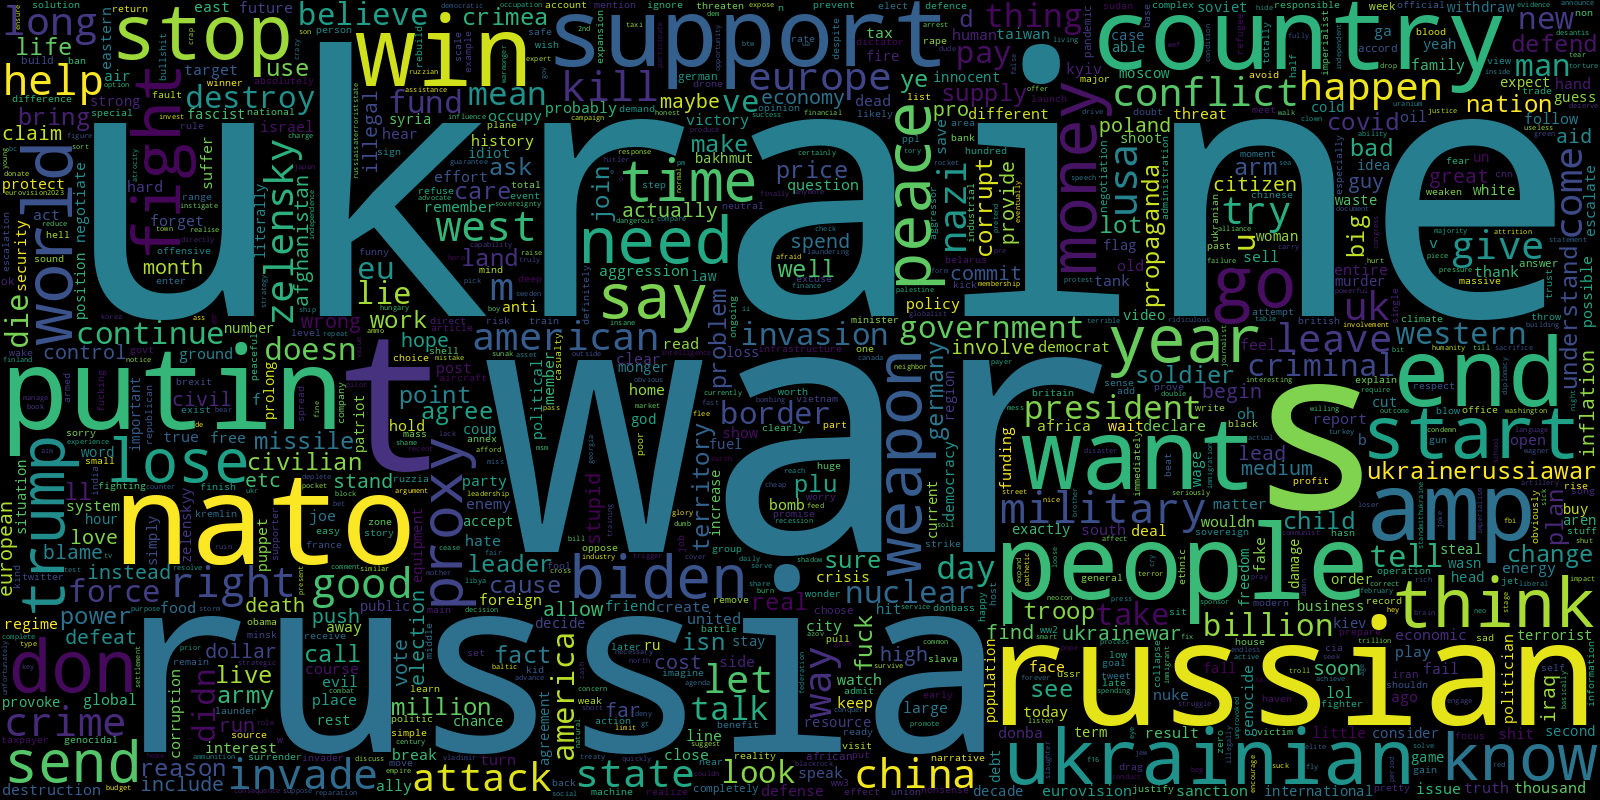

In [ ]:
wc.to_image()

# Tokenizacja

In [ ]:
tweets_model = tweets.copy()
tweets_model.text = tweets_model.text.apply(lambda x: x.split())
tweets_model = tweets_model[tweets_model.text.str.len()>1]
tweets_model.reset_index(inplace=True) #potrzebne potem, ponieważ jeżeli tego nie dodam to tworzenie słowników tfidf się desynchronizuje indeksowo.

In [ ]:
sentiment = [row for row in tweets_model.text]
phrases = Phrases(sentiment, min_count=1, progress_per=1000)
bigram = Phraser(phrases)
sentences = bigram[sentiment]
sentences[1]

['turn', 'starlink', 'stop', 'war', 'ukraine']

In [ ]:
tweets_export = tweets_model.copy()
tweets_export['old_text'] = tweets_export.text
tweets_export.old_title = tweets_export.old_text.str.join(' ')
tweets_export.text = tweets_export.text.apply(lambda x: ' '.join(bigram[x]))
tweets_export.sample(10)

<ipython-input-459-3e1ef2b887eb>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tweets_export.old_title = tweets_export.old_text.str.join(' ')


,index,text,created_at,likes,retweets,impressions,old_text
2753,2835,war ukraine expect_significant topic_discussio...,2023-05-18 16:14:05+00:00,0,0,45,"[war, ukraine, expect, significant, topic, dis..."
26402,28071,russian war crime,2023-05-15 10:03:51+00:00,0,0,28,"[russian, war, crime]"
24635,26109,head clash biblical titans communism christian...,2023-05-15 14:23:58+00:00,2,1,39,"[head, clash, biblical, titans, communism, chr..."
26485,28163,begin war half lviv speak rusian displace peop...,2023-05-15 09:49:44+00:00,5,0,235,"[begin, war, half, lviv, speak, rusian, displa..."
6190,6584,russia imperialist retard ukraine imperialist ...,2023-05-18 02:31:57+00:00,0,0,37,"[russia, imperialist, retard, ukraine, imperia..."
24209,25659,damn right ! thing s efficient pay tax governm...,2023-05-15 15:24:07+00:00,10,0,248,"[damn, right, !, thing, s, efficient, pay, tax..."
29052,30896,russia country employ widespread social imperi...,2023-05-14 22:59:29+00:00,8,1,114,"[russia, country, employ, widespread, social, ..."
4984,5311,look_like war ukraine reach baby blitz stage s...,2023-05-18 08:35:15+00:00,0,0,18,"[look, like, war, ukraine, reach, baby, blitz,..."
18943,20110,2 3bn ukraine centrist mum dad cream fighting ...,2023-05-16 08:44:26+00:00,3,0,103,"[2, 3bn, ukraine, centrist, mum, dad, cream, f..."
34731,37076,ruzzia start war ukraine stop netflix produce ...,2023-05-14 05:40:33+00:00,0,0,381,"[ruzzia, start, war, ukraine, stop, netflix, p..."


In [ ]:
tweets_export[['text', 'created_at', 'impressions']].to_csv(f'{path_to_work_folder}cleaned_tweets.csv', index=False)

# Word Embeddings

In [ ]:
w2v_model = Word2Vec(min_count=5,
                     window=5,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)
w2v_model.build_vocab(sentences, progress_per=50000)

In [ ]:
w2v_model.train(sentences,
                total_examples=w2v_model.corpus_count,
                epochs=100,
                report_delay=1)
w2v_model.init_sims(replace=True)

<ipython-input-462-714895e57515>:5: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [ ]:
w2v_model.save(f'{path_to_work_folder}word2vec.model')

# Labeling

Odnośnie hiperparametrów K-Means, podczytałem tutaj: https://www.sciencedirect.com/science/article/pii/S0031320319301608 odnośnie najlepszych hiperparametrów, ale wydaje mi się, że jedyne, co mi to dało, to ogólne guidelines odnośnie rzędów wielkości niż świętego grala uniwersalnego K-Means.

In [91]:
from sklearn.cluster import KMeans

word_vectors = Word2Vec.load(f'{path_to_work_folder}word2vec.model').wv

model = KMeans(n_clusters=2,
               max_iter=5000,
               random_state=True,
               n_init=20,
               tol=0.001,
               )
model.fit(X=word_vectors.vectors.astype('double'))

KMeans(max_iter=5000, n_clusters=2, n_init=20, random_state=True, tol=0.001)

In [92]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=50, restrict_vocab=None)

[('destroyer', 0.6890656352043152),
 ('kamala', 0.685111939907074),
 ('plandemic', 0.6780705451965332),
 ('finish_wall', 0.670903205871582),
 ('fail_bank', 0.6693873405456543),
 ('manufacture_crisis', 0.6633709073066711),
 ('mandatory', 0.6605609059333801),
 ('climate_hoax', 0.6546682119369507),
 ('impeach_biden', 0.648341178894043),
 ('cut_social', 0.6461420059204102),
 ('border_secure', 0.6451750993728638),
 ('smokescreen', 0.6432669162750244),
 ('election_steal', 0.6420917510986328),
 ('gouge', 0.6413827538490295),
 ('quit_send', 0.6371740698814392),
 ('rinos', 0.6357976198196411),
 ('pay_pension', 0.6345713138580322),
 ('convid', 0.6344571709632874),
 ('govt_spend', 0.6342928409576416),
 ('economy_thrive', 0.6328133344650269),
 ('border_wide', 0.6306045055389404),
 ('fleece', 0.6294951438903809),
 ('recession_cause', 0.6294137239456177),
 ('grifte', 0.6278191804885864),
 ('fruit', 0.626968264579773),
 ('totally_corrupt', 0.6244287490844727),
 ('populist', 0.6239200234413147),
 ('ba

In [93]:
positive_cluster_index = 0
negative_cluster_index = 1

positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[negative_cluster_index]

In [94]:
df = pd.DataFrame(word_vectors.index_to_key)
df.columns = ['Word']
df["Embedding_Vector"] = df.Word.apply(lambda x: word_vectors[f'{x}'])
df["Cluster"] = df.Embedding_Vector.apply(lambda x: model.predict([np.array(x)]))
df.Cluster = df.Cluster.apply(lambda x: x[0])
df['Cluster_Value'] = [1 if i==positive_cluster_index else -1 for i in df.Cluster]
df['Closeness_Score'] = df.apply(lambda x: 1/(model.transform([x.Embedding_Vector]).min()), axis=1)
df['Sentiment_Coeff'] = df.Closeness_Score * df.Cluster_Value

In [95]:
df.sample(50)

,Word,Embedding_Vector,Cluster,Cluster_Value,Closeness_Score,Sentiment_Coeff
6001,masters,"[0.03594598, 0.024744218, -0.05180748, 0.01121...",1,-1,1.085414,-1.085414
5275,critical_infrastructure,"[0.028778575, -0.048804358, 0.023061637, 0.044...",0,1,1.109600,1.109600
308,hit,"[0.082208745, 0.022264605, 0.038008396, 0.0668...",0,1,1.057965,1.057965
1240,neutrality,"[-0.0099915825, 0.07649785, 0.014600545, -0.11...",0,1,1.050147,1.050147
6160,couple_year,"[0.04177071, 0.034891497, -0.01153804, -0.1202...",1,-1,1.051238,-1.051238
531,receive,"[0.04167721, 0.035383523, 0.060458515, 0.08206...",0,1,1.023244,1.023244
733,military_industrial,"[-0.032015964, 0.041785512, -0.008583026, 0.00...",1,-1,1.039682,-1.039682
806,diplomacy,"[-0.08395902, 0.023216246, 0.009603691, 0.0570...",0,1,1.039801,1.039801
4659,untill,"[-0.017222578, -0.0558398, -0.025076272, 0.049...",0,1,1.080117,1.080117
2756,concession,"[-0.004045615, 0.113622, -0.04222447, 0.020730...",0,1,1.046898,1.046898


In [96]:
df[['Word', 'Sentiment_Coeff']].to_csv(f'{path_to_work_folder}Sentiment_Dict.csv', index=False)

In [97]:
sentiment_dict = dict(zip(df.Word.values, df.Sentiment_Coeff.values))

In [102]:
tweets_export = pd.read_csv(f'{path_to_work_folder}cleaned_tweets.csv')
tweets_export.head(10)

,text,created_at,impressions
0,d like propose ukraine u win t come s war,2023-05-19 02:22:55+00:00,2
1,turn starlink stop war ukraine,2023-05-19 02:22:20+00:00,0
2,everybody_hate russia terrorist war wage ukraine,2023-05-19 02:22:13+00:00,0
3,infrastructure_bill pass low drug cost pass st...,2023-05-19 02:21:06+00:00,4
4,trigger_article 5 nuclear war ? hell pal want ...,2023-05-19 02:20:32+00:00,0
5,course ukraine belong nato russia putin war cr...,2023-05-19 02:20:31+00:00,3
6,britton supply storm_shadow missiles ukraine w...,2023-05-19 02:20:29+00:00,0
7,republican president 2024 end biden s endless ...,2023-05-19 02:20:29+00:00,4
8,probably_wouldn t prop russia / ukraine war,2023-05-19 02:20:22+00:00,7
9,forget bakhmut importance slava ukraine,2023-05-19 02:20:17+00:00,12


In [103]:
weighting_file = tweets_export.copy()
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(weighting_file.text)
features = pd.Series(tfidf.get_feature_names_out())
transformed = tfidf.transform(weighting_file.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


**Potrzebne metody - (prawie) kopiuj-wklej z ćwiczeń**

In [104]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)
    return list(map(lambda y:dictionary[f'{y}'], x.text.split()))

def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [105]:
replaced_tfidf_scores = weighting_file.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)
replaced_closeness_scores = weighting_file.text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [106]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, weighting_file.text]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')

In [107]:
replacement_df[replacement_df['prediction'] == 0].sample(50)

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction
15626,"[-1.0615468529494843, 1.0763038430478886, 1.04...","[3.7644207596480794, 1.053121962782922, 3.4713...",think war win ukraine demolish ant people_suff...,-4.041094,0
4185,"[1.0427127839918642, -1.1132328629809316, 1.03...","[4.015086784599411, 9.159184024464368, 7.54974...",say economic_crisis mainly external covid amp ...,-115.180001,0
14702,"[1.0716417428315226, -1.021342869987165, -1.03...","[5.917242926665171, 6.961959447128149, 9.00503...",expect cry boot s ground ukraine ! ? start wor...,-10.379706,0
20397,"[1.0491814795659014, -1.0470651004174345, 1.03...","[3.362366683840978, 3.477306385196217, 5.39026...",putin want civil war division amp chaos help u...,-21.862469,0
32862,"[-1.0615468529494843, 0, 1.1190894715228257, -...","[3.7644207596480794, 10.545478385584259, 3.412...",think ll_clarify russian jew bear ukraine citi...,-24.446364,0
2416,"[1.1194045451666144, 1.0367069976187342, 0, -1...","[6.180258869226758, 6.1428324637076415, 10.545...",moscow order arrest_prominent producer directo...,-48.244102,0
136,"[-1.1046545601941395, 1.0978071128052564, 1.07...","[7.980529028122723, 1.042319157051143, 1.05312...",money_spend ukraine war divert_troop veteran,-14.355042,0
10070,"[0, -1.0301616138430056, 1.0275199451894357, 1...","[10.950943493692423, 7.906421055969, 8.4252148...",ooof bias display refer trump reagan administr...,-85.072615,0
19614,"[-1.0214770549531946, 1.1076693065664136, -1.0...","[4.6328766869020015, 9.405801238367989, 6.1510...",china attack taiwan startegic interest russia ...,-18.559345,0
12268,"[-1.0147915054728618, -1.0882500980395085, 1.0...","[7.424582969076262, 7.24964151957993, 8.311886...",brother pick excellent tweet thanks usa agency...,-53.570518,0


In [108]:
replacement_df[replacement_df['prediction'] == 1].sample(50)

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction
20479,"[1.061295025339394, 1.0587868162789293, 1.0622...","[4.604430324390293, 7.300285252398685, 5.02268...",mean invading 2014 take_chunk land agree war i...,55.367893,1
17563,"[1.0978071128052564, 1.0664978058759638, 1.070...","[3.126957471153429, 6.784278269890697, 6.24141...",ukraine near able join_nato t join_nato war 20...,44.408700,1
37213,"[1.1092326761088576, -1.0351453989069963, 1.04...","[2.0743291326694284, 6.738815895813939, 2.3133...",russia deserve s come godspeed afu ballistic_m...,43.973761,1
37104,"[-1.0486143285467249, 1.0978071128052564, 1.07...","[3.5279722426430027, 1.042319157051143, 1.0531...",support ukraine war ? rethink stance early pos...,24.856730,1
5027,"[1.0978071128052564, -1.071962028449552, 0, -1...","[1.042319157051143, 5.116132756629819, 10.2577...",ukraine well launch_pad proxy war lack democra...,25.783499,1
15405,"[0, 1.032611046959245, 0, 0, 1.046529768012645...","[10.545478385584259, 4.445159433564195, 10.545...",process_multipolarity happen aspect_direct con...,14.441580,1
40011,"[1.0294233718766144, -1.0397134683628544, 1.05...","[8.599568236528945, 9.564649132572534, 7.78351...",gaza pple fight combine_force eu australia uk_...,47.479953,1
20639,"[1.068077506203627, 1.0465297680126457, 0, 1.0...","[4.432533940938567, 4.626608298400638, 10.0346...",way s regulate militia s voluntary service loo...,31.311789,1
16946,"[1.0864895038413893, 1.026012073655536, 1.0465...","[12.81529742284484, 6.095014589357149, 2.31330...",defense 100 s small war available gepard ukrai...,75.151057,1
17698,"[1.0465297680126457, -1.0541517781410732, 1.02...","[4.626608298400638, 5.240516476317554, 6.34078...",s lot video youtube poor city s sad look_like ...,3.707116,1


In [109]:
replacement_df.groupby(['prediction']).count()

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate
prediction,,,,
0,17025,17025,17025,17025
1,24918,24918,24918,24918


# Zebranie do datasetu

In [110]:
dataset = replacement_df[["sentence", "prediction"]]

In [111]:
dataset.to_csv(f'{path_to_work_folder}ready_dataset.csv', index=False, header=None)

# Podział na dane treningowe i testowe

In [48]:
data = read_csv(f'{path_to_work_folder}ready_dataset.csv', header=None, names=['text','target'])

In [49]:
data.head(10)

,text,target
0,d like propose ukraine u win t come s war,0
1,turn starlink stop war ukraine,0
2,everybody_hate russia terrorist war wage ukraine,1
3,infrastructure_bill pass low drug cost pass st...,0
4,trigger_article 5 nuclear war ? hell pal want ...,0
5,course ukraine belong nato russia putin war cr...,1
6,britton supply storm_shadow missiles ukraine w...,1
7,republican president 2024 end biden s endless ...,0
8,probably_wouldn t prop russia / ukraine war,0
9,forget bakhmut importance slava ukraine,1


In [50]:
X_train, X_Test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.1, stratify=data.target, random_state=42)

# Klasyczny ML

In [51]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [52]:
X_train = vectorizer.transform(X_train)
X_Test = vectorizer.transform(X_Test)

**Bernoulli**

In [53]:
bernoulli = BernoulliNB()
bernoulli.fit(X_train, y_train)

BernoulliNB()

In [54]:
y_pred = bernoulli.predict(X_Test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.35      0.51      1703
           1       0.69      0.99      0.81      2492

    accuracy                           0.73      4195
   macro avg       0.83      0.67      0.66      4195
weighted avg       0.80      0.73      0.69      4195



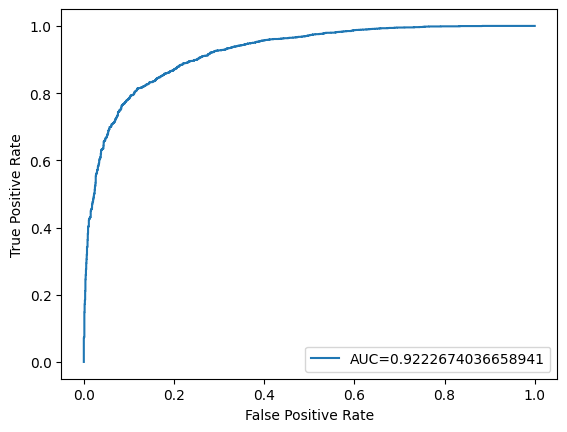

In [55]:
y_pred_proba = bernoulli.predict_proba(X_Test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

**Regresja logistyczna**

In [56]:
log_regression = LogisticRegression()
log_regression.fit(X_train,y_train)

LogisticRegression()

In [57]:
y_pred = log_regression.predict(X_Test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1703
           1       0.84      0.90      0.87      2492

    accuracy                           0.84      4195
   macro avg       0.84      0.82      0.83      4195
weighted avg       0.84      0.84      0.84      4195



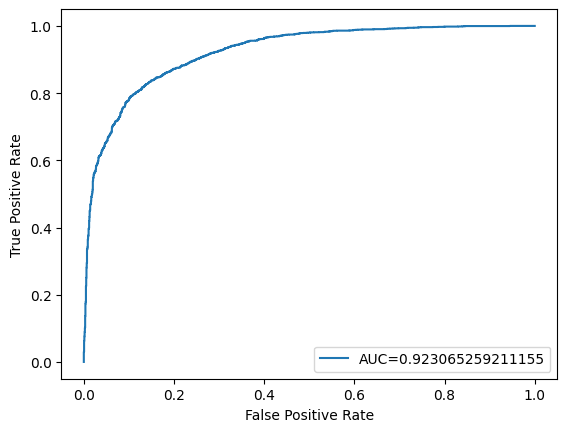

In [58]:
y_pred_proba = log_regression.predict_proba(X_Test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

**Drzewo decyzyjne**

In [59]:
dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [60]:
y_pred = dec_tree.predict(X_Test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.55      0.55      1703
           1       0.69      0.70      0.70      2492

    accuracy                           0.64      4195
   macro avg       0.63      0.63      0.63      4195
weighted avg       0.64      0.64      0.64      4195



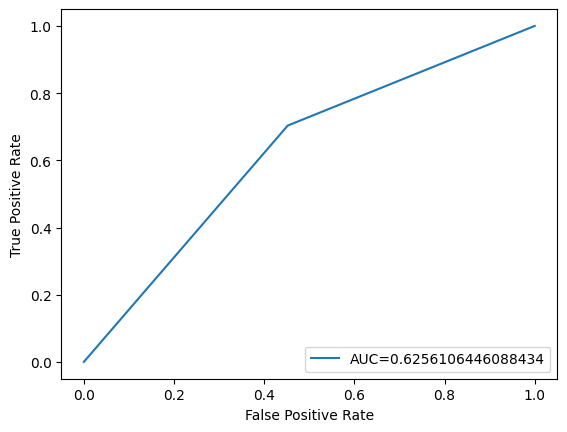

In [61]:
y_pred_proba = dec_tree.predict_proba(X_Test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Model sieci neuronowej

Postanowiłem pobawić się trochę w szalonego naukowca tutaj - próbuję użyć zarówno Tf-Idf scores jak i Embeddingów.

In [127]:
data = read_csv(f'{path_to_work_folder}ready_dataset.csv', header=None, names=['text','target'])
X_train, X_Test, y_train, y_test = train_test_split(data.text, data.target, test_size=0.1, stratify=data.target, random_state=42)

In [128]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [129]:
maxlen = 50
embedding_size = 300

In [130]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_train = pad_sequences(sequences_train, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

In [131]:
vectorizer = TfidfVectorizer(max_features=embedding_size)
vectorizer = vectorizer.fit(X_train)

df_train = vectorizer.transform(X_train)

In [132]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers

tf.config.run_functions_eagerly(True)

input_tfidf = layers.Input(shape=(300,))
input_text = layers.Input(shape=(maxlen,))

embedding = layers.Embedding(vocab_size, embedding_size, input_length=maxlen)(input_text)

# Metoda zapożyczona z:
# https://stackoverflow.com/a/54217709/1987598
# oraz z:
# https://stackoverflow.com/questions/60195735/use-tf-idf-with-in-keras-model

mean_embedding = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1))(embedding)

concatenated = layers.concatenate([input_tfidf, mean_embedding])

dense1 = layers.Dense(256, activation='relu')(concatenated)
dense2 = layers.Dense(32, activation='relu')(dense1)
x = layers.Dropout(0.2)(dense2)
outputs = layers.Dense(2, activation="sigmoid")(x)
model = keras.Model(inputs=[input_tfidf, input_text], outputs=outputs)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [133]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f'{path_to_work_folder}checkpointModel.keras',
        monitor="val_loss",
        save_best_only=True,
    )
]

In [134]:
from scipy.sparse import csr_matrix
df_train = df_train.toarray()

In [136]:
history = model.fit(
    [df_train, sequences_train],
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks_list
    )

Epoch 1/100
1062/1062 [==============================] - 201s 189ms/step - loss: 0.3489 - accuracy: 0.8461 - val_loss: 0.3271 - val_accuracy: 0.8532
Epoch 2/100
1062/1062 [==============================] - 199s 187ms/step - loss: 0.2342 - accuracy: 0.9038 - val_loss: 0.3395 - val_accuracy: 0.8551
Epoch 3/100
1062/1062 [==============================] - 196s 185ms/step - loss: 0.1804 - accuracy: 0.9279 - val_loss: 0.3783 - val_accuracy: 0.8575
Epoch 4/100
1062/1062 [==============================] - 197s 186ms/step - loss: 0.1405 - accuracy: 0.9416 - val_loss: 0.4596 - val_accuracy: 0.8530
Epoch 5/100
1062/1062 [==============================] - 203s 191ms/step - loss: 0.1114 - accuracy: 0.9544 - val_loss: 0.5309 - val_accuracy: 0.8538


In [137]:
model = keras.models.load_model(f'{path_to_work_folder}checkpointModel.keras')

In [138]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_Test)

sequences_test = tokenizer.texts_to_sequences(X_Test)
sequences_test = pad_sequences(sequences_test, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

vectorizer = TfidfVectorizer(max_features=embedding_size)
vectorizer = vectorizer.fit(X_Test)

df_test = vectorizer.transform(X_Test)
df_test = df_test.toarray()

In [139]:
print(f"Test acc: {model.evaluate([df_test, sequences_test], y_test)[1]:.3f}")

132/132 [==============================] - 2s 18ms/step - loss: 0.8604 - accuracy: 0.5733
Test acc: 0.573


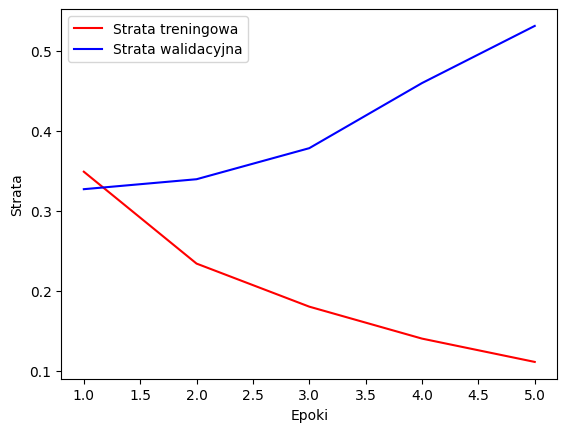

In [140]:
import matplotlib.pyplot as plt

epochs = range(1,len(history.history["loss"]) + 1)
loss = history.history['loss'] 
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'r', label='Strata treningowa') 
plt.plot(epochs, val_loss, 'b', label='Strata walidacyjna') 
plt.xlabel('Epoki') 
plt.ylabel('Strata') 
plt.legend() 
plt.show()

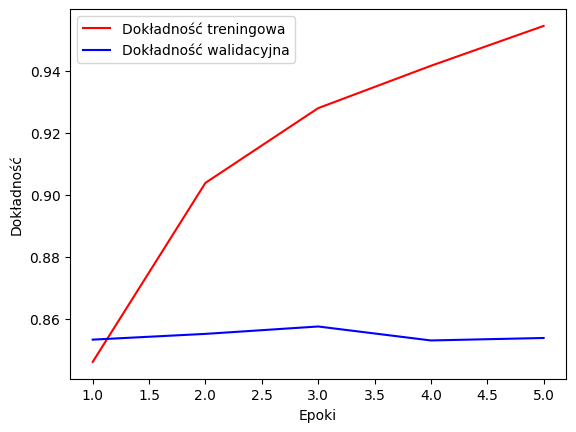

In [141]:
plt.clf()
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r', label='Dokładność treningowa') 
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacyjna') 
plt.xlabel('Epoki') 
plt.ylabel('Dokładność') 
plt.legend() 
plt.show()

# BERT

In [1]:
!pip install transformers==4.27.1 -q #Nowsza wersja wyrzucała błędy, także tutaj downgrade
!pip install -U datasets -q
#!pip install -U accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.9 MB/s eta 0:00:00


In [19]:
from datasets import Dataset, load_metric
import transformers
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [20]:
data = read_csv(f'{path_to_work_folder}ready_dataset.csv', header=None, names=['text','target'])
data.rename(columns={'target':'label'}, inplace=True)

In [21]:
dataset_ = Dataset.from_pandas(data)
dataset = dataset_.train_test_split(0.1)

In [22]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 37748
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4195
    })
})


In [23]:
model_checkpoint = 'distilbert-base-uncased'
batch_size = 128

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [25]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
test_ds = dataset['test'].map(process)

Map:   0%|          | 0/37748 [00:00<?, ? examples/s]

Map:   0%|          | 0/4195 [00:00<?, ? examples/s]

In [26]:
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [27]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [29]:
trainer.evaluate([train_ds[0]])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7204614877700806,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.0274,
 'eval_samples_per_second': 36.473,
 'eval_steps_per_second': 36.473}

In [30]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.335561,0.849583
2,0.363800,0.328113,0.858403
3,0.363800,0.310643,0.863170
4,0.239600,0.317767,0.867700
5,0.239600,0.324395,0.870560


TrainOutput(global_step=1475, training_loss=0.26298323291843223, metrics={'train_runtime': 834.6566, 'train_samples_per_second': 226.129, 'train_steps_per_second': 1.767, 'total_flos': 2652599633796384.0, 'train_loss': 0.26298323291843223, 'epoch': 5.0})

In [31]:
trainer.evaluate(train_ds)

{'eval_loss': 0.12983505427837372,
 'eval_accuracy': 0.952341845925612,
 'eval_runtime': 56.2479,
 'eval_samples_per_second': 671.1,
 'eval_steps_per_second': 5.245,
 'epoch': 5.0}

# Podsumowanie

Dokładność wszystkich modeli (ewaluacyjna)

Bernoulli:
image.png

Regresja Liniowa: image.png

Drzewo decyzyjne: image.png

Model sieci neuronowej: image.png

BERT: image.png

Dumpowanie pozostałych, niezapisanych modeli do plików

In [63]:
import pickle
file1 = open(f'{path_to_work_folder}bernoulli.model', 'wb')
file2 = open(f'{path_to_work_folder}log_regression.model', 'wb')
file3 = open(f'{path_to_work_folder}dec_tree.model', 'wb')

pickle.dump(bernoulli, file1)
pickle.dump(log_regression, file2)
pickle.dump(dec_tree, file3)
trainer.save_model(f'{path_to_work_folder}BERTtrainedModel.model')

file1.close()
file2.close()
file3.close()